# 1. INTRODUCTION

**Last Update**: 5 July 2022

# 2. IMPORTS

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 8.4 MB/s 
     |████████████████████████████████| 1.2 MB 55.1 MB/s 
     |████████████████████████████████| 4.4 MB 58.1 MB/s 
     |████████████████████████████████| 362 kB 54.1 MB/s 
     |████████████████████████████████| 212 kB 60.3 MB/s 
     |████████████████████████████████| 1.1 MB 48.7 MB/s 
     |████████████████████████████████| 140 kB 58.8 MB/s 
     |████████████████████████████████| 101 kB 7.4 MB/s 
     |████████████████████████████████| 596 kB 58.5 MB/s 
     |████████████████████████████████| 127 kB 6.6 MB/s 
     |████████████████████████████████| 144 kB 30.1 MB/s 
     |████████████████████████████████| 94 kB 3.4 MB/s 
     |████████████████████████████████| 271 kB 47.9 MB/s 
     |████████████████████████████████| 6.6 MB 33.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6

In [ ]:
#hide
from fastbook import *

In [ ]:
from fastai.text.all import *
import pandas as pd
import matplotlib.pyplot as plt
import re
import math
import seaborn as sn
import spacy

# 3. CONSTS

1. `RELIGIONS`
2. `SOCIAL_FIELDS`
3. `DATA_PATH`
4. `NLP`

In [ ]:
RELIGIONS = ["atheism", "christianity", "islam", "unspecific", "hindu", "buddhism", "judaism", "others", "jainism", "none"]

In [ ]:
SOCIAL_FIELDS = ["religion", "politics", "others", "economy", "media", "art", "science", "ethics", "education"]

In [ ]:
DATA_PATH = Path.cwd()/'gdrive'/'MyDrive'

In [ ]:
NLP = spacy.load("en_core_web_sm")

# 4. FUNCTIONS

1. `clean_tweet` -> cleaning a Tweet (removing hyperlinks and noise)
2. `column_splitter` -> several functions for pandas.apply() to split multi-label columns in separate columns with one-hot encoding
3. `create_df` -> creating a DataFrame from an Excel file incl. several operations such as One-Hot encoding, creating label column etc.
4. `create_full_df` -> create a df with all `xlsx` files from a certain folder
5. `phi_coef` and `phi_coef_matrix`-> implementation of phi coefficient for correlation between two binary columns
6. `predict_tweets` -> predict tweets in a DataFrame based on a passed model
8. `save_tweets_for_corpus_linguistics` -> function used in the final step to store selected tweets for external examinations with, for instance, corpus linguistics

## 4.1 Clean Tweets

In [ ]:
def clean_tweet(tweet, lemmatize=False):
  '''
  function to clean tweets
  '''
  pattern = re.compile(r'@\w+|http[s]*\://[\w\./]+|[\.,:;\n\t\"\'-\?“”#&]+')
  clean_tweet = re.sub(pattern, ' ', tweet)
  clean_tweet = re.sub(r'\s{2,}', ' ', clean_tweet)
  clean_tweet = clean_tweet.strip().lower()
  # (optional) lemmatization
  if lemmatize:
    doc = NLP(clean_tweet)
    clean_tweet = ' '.join([word.lemma_ for word in doc])
  return clean_tweet


In [ ]:
# test clean_tweet
clean_tweet("@you #mullman please goes wanted to I thought to this links: https://www.google.com and then go somewhere else")

'mullman please goes wanted to i thought to this links and then go somewhere else'

----------------

## 4.2 Column Splitter

In [ ]:
def column_splitter_religion(row):
  '''
  helper function to apply to multi-label columns to encode label in separate religion column
  '''
  for rel in RELIGIONS:
    if rel in row['religions'].split(' '):
      row[rel] = 1
  return row

In [ ]:
def column_splitter_social_fields(row):
  '''
  helper function to apply to multi-label columns to encode label in separate social field column
  '''
  for sf in SOCIAL_FIELDS:
    if sf in row['social_spheres'].split(' '):
      row[sf] = 1
  return row

---------------------

## 4.3 Prepare DataFrame

Helper method for `create_df` and `create_full_df`.

In [ ]:
def prepare_df(df, lemmatize):
  '''
  helper function to prepare a raw DataFrame with annotations and tweets for analysis

  '''
  # remove Unnamed Column if in df
  if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)
  
  # renaming 'religion' column to avoid later overwriting
  df.rename(columns= {'religion': 'religions'}, inplace=True)

  # creating clean version of tweets in separate column
  df['clean_tweet'] = df['text'].apply(partial(clean_tweet, lemmatize=lemmatize))
  
  # creating multi-label column (categorical data) 
  df['ron'] = df.ron.astype('int32')
  df['ron'] = df.ron.astype('category')

  # encoding religions
  ## first creating column for each religion
  df[RELIGIONS] = 0
  df = df.apply(column_splitter_religion, axis=1)

  # encoding social fields
  ## first creating zero column for each social field
  df[SOCIAL_FIELDS] = 0
  df = df.apply(column_splitter_social_fields, axis=1)

  # one-hot encoding for sentiments
  df= pd.concat([df, pd.get_dummies(df['sentiment'])], axis=1)

  # one-hot encoding for ron
  df= pd.concat([df, pd.get_dummies(df['ron'])], axis=1)

  # drop duplicates based o clean_tweet column
  df.drop_duplicates(subset=['clean_tweet'], ignore_index=True, inplace=True)

  return df

---------------------

## 4.4 Create DataFrame

In [ ]:
def create_df(path=DATA_PATH/'Twitter'/'Religion'/'DHQ'/'train'/'twitter_rel_2022-5-31.xlsx', index_col=0):
  '''
  creating a pandas DataFrame from an annotated Excel file with tweets

  arguments:
  ----------
  path: the path to the Excel file
  index_col: the index column (pandas arg)

  input Excel file structure:
  ---------------------
  idx: index
  tweet: tweet text
  hashtags: parsed hashtags
  ron: multi-label column (1-5)
  religion: multi-label religions (christianity, multiple, unspecific, hindu, buddhism, judaism, atheism, islam) - NOT IN 1NF! (incl. list)
  social_spheres: multi-label social spheres (politics, economy, religion, ethics, art, media, others) - NOT IN 1NF! (incl. list)
  sentiment: categorical column (pos, neu, neg)

  '''
  df = pd.read_excel(path, index_col=index_col)
  
  df = prepare_df(df)

  return df

## 4.5 Create Full DF

Create a DataFrame that includes all `xlsx` files from a certain folder.

In [ ]:
def create_full_df(path=DATA_PATH/'Twitter'/'Religion'/'DHQ'/'train', lemmatize=True):
  '''
  create a DataFrame including all xlsx files from a folder in path

  Arguments:
  ----------
  path: the path to the folder


  Return:
  -------
  DataFrame with Tweets and annotations OR None if no files found in folder.
  '''
  # no files in folder
  try:
    next(path.glob('*.xlsx'))
  except StopIteration:
    print("No files found!")
    return None
 
  # creating DataFrame from each single Excel file in folder
  df = pd.concat(map(pd.read_excel, path.glob('*.xlsx')))
  
  # preparing DataFrame for analysis
  df = prepare_df(df, lemmatize=lemmatize) 
  
  return df




## 4.6 Phi Coefficient

Implementaton of: <https://en.wikipedia.org/wiki/Phi_coefficient>.

In [ ]:
def phi_coef(df, col1, col2):
  '''
  phi coefficient of two binary columns

  arguments:
  ----------
  df:       DataFrame
  col1:     string of first column
  col2:     string of second column 
  '''

  n11 = len(df[(df[col1] == 1) & (df[col2]==1)])
  n00 = len(df[(df[col1] == 0) & (df[col2]==0)])
  n10 = len(df[(df[col1] == 1) & (df[col2]==0)])
  n01 = len(df[(df[col1] == 0) & (df[col2]==1)])
  #print(f"n11: {n11} n00: {n00} n10: {n10} n01: {n01}")

  n1x = n11 + n10
  n0x = n01 + n00
  nx1 = n11 + n01
  nx0 = n10 + n00

  phi_coef = (n11*n00 - n10*n01) / (math.sqrt(n1x*n0x*nx1*nx0))

  #print(f"n11: {n11} n00: {n00} n10: {n10} n01: {n01} phi_coef: {phi_coef}")
  return phi_coef

In [ ]:
def phi_coef_matrix(df, columns):
  '''
  creating a matrix with phi coefficients from a selection of columns in a DataFrame

  arguments:
  ----------
  df:       the DataFrame
  columns:  the selected columns from the DataFrame to compare with each other
  '''
  dict_ = dict()

  for col1 in columns:
    dict_[col1] = dict()
    for col2 in columns:
       dict_[col1][col2] = phi_coef(df, col1, col2)
  return pd.DataFrame.from_dict(dict_, orient="index")

In [ ]:
# testing 

df_test = pd.DataFrame({'col1': [0,1,1,0,1], 'col2': [1,0,1,0,1]})
phi_coef(df_test, 'col1', 'col2')

0.16666666666666666

## 4.7 Predict Tweets

Predicting tweets (`clean_tweet`) in a DataFrame based on a passed model (classifier).

In [ ]:
def predict_tweets(df, model):
  '''
  arguments:
  ----------
  df: The DataFrame that needs to have a column 'clean_tweet'
  model: the trained classifier that makes the prediction
  '''

  df['y_hat'] = df['clean_tweet'].apply(lambda x: model.predict(x)[0])
  df['y_hat'] = df.y_hat.astype('int8')
  
  return df

## 4.8 Save Tweets for Corpus Linguistics

Saving filtered tweets for external analysis with corpus linguistics.

In [ ]:
def save_tweets_for_corpus_linguistics(df, path, lemmatize=True):
  '''
  function to store tweets in separate files in a folder for further examination with corpus linguistics

  arguments:
  ----------
  df: the filtered dataframe with the tweets that should be stored
  path: the path to the folder where these images should be stored
  lemmatize: (bool) lemmatize tweets

  return:
  -------
  None
  '''
  counter = len(df)

  for i in range(counter):
    lemmatized_tweet = clean_tweet(df.iloc[i]['text'], lemmatize=lemmatize)
    with open(path+str(i)+'.txt', 'w', encoding="utf-8") as f:
      f.write(lemmatized_tweet)

  return None

# 5. LOAD DATA & SANITY CHECKS

In [ ]:
#TextDataLoaders.from_csv(data_path/'Twitter'/'Religion', csv_fname='test.csv', text_col=1, label_col=2)

In [ ]:
df = create_full_df(lemmatize=False)

In [ ]:
# show all religions in frame
_ = set()

def unique_rels(x):
  _.update(x.split(' '))

df.religions.apply(unique_rels)
_

{'atheism',
 'buddhism',
 'christianity',
 'hindu',
 'islam',
 'jainism',
 'judaism',
 'none',
 'others',
 'unspecific'}

In [ ]:
# show all social spheres in frame
_ = set()

def unique_rels(x):
  _.update(x.split(' '))

df.social_spheres.apply(unique_rels)
_

{'art',
 'economy',
 'education',
 'ethics',
 'media',
 'others',
 'politics',
 'religion',
 'science'}

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1530 entries, 0 to 1529
Data columns (total 34 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              1529 non-null   float64
 1   text            1530 non-null   object 
 2   hashtags        186 non-null    object 
 3   ron             1530 non-null   int64  
 4   religions       1530 non-null   object 
 5   social_spheres  1530 non-null   object 
 6   sentiment       1530 non-null   object 
 7   clean_tweet     1530 non-null   object 
 8   atheism         1530 non-null   int64  
 9   christianity    1530 non-null   int64  
 10  islam           1530 non-null   int64  
 11  unspecific      1530 non-null   int64  
 12  hindu           1530 non-null   int64  
 13  buddhism        1530 non-null   int64  
 14  judaism         1530 non-null   int64  
 15  others          1530 non-null   int64  
 16  jainism         1530 non-null   int64  
 17  none            1530 non-null   i

In [ ]:
df.head(2)

,id,text,hashtags,ron,religions,social_spheres,sentiment,clean_tweet,atheism,christianity,islam,unspecific,hindu,buddhism,judaism,others,jainism,none,religion,politics,economy,media,art,science,ethics,education,neg,neu,pos,1,2,3,4,5
0,0.0,music is like religion to me.,NaN,4,unspecific,art,pos,music is like religion to me,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
1,1.0,sport is my religion.,NaN,4,unspecific,others,pos,sport is my religion,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


# 6. EXPLORATORY DATA ANALYSIS

## 6.1 `RON` Distribution

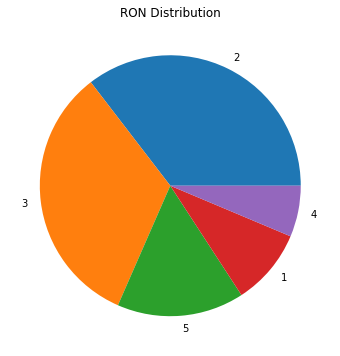

In [ ]:
df.value_counts('ron').plot(kind="pie", figsize=(6,6), title="RON Distribution", ylabel="")
plt.savefig('ron_distribution.png')

In [ ]:
df.value_counts('ron', normalize=True) * 100

ron
2    35.424837
3    33.006536
5    15.751634
1     9.477124
4     6.339869
dtype: float64

## 6.2 `religions` Distribution

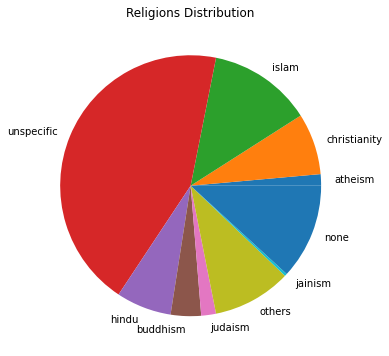

In [ ]:
df[RELIGIONS].apply(pd.Series.value_counts).iloc[1,:].plot(kind="pie", figsize=(6,6), title="Religions Distribution", ylabel="")
plt.savefig('religions_distribution.png')

In [ ]:
(df[RELIGIONS].apply(pd.Series.value_counts) /df[RELIGIONS].apply(pd.Series.value_counts).sum()) * 100

,atheism,christianity,islam,unspecific,hindu,buddhism,judaism,multiple,others,jainism,none
0,98.169935,90.196078,83.464052,43.594771,91.176471,95.163399,97.647059,100.0,87.45098,99.607843,84.771242
1,1.830065,9.803922,16.535948,56.405229,8.823529,4.836601,2.352941,NaN,12.54902,0.392157,15.228758


&nbsp;

## 6.3 `social_spheres` Distribution

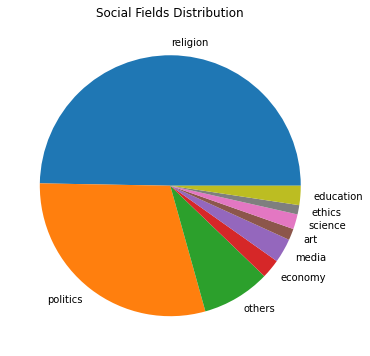

In [ ]:
df[SOCIAL_FIELDS].apply(pd.Series.value_counts).iloc[1,:].plot(kind="pie", figsize=(6,6), title="Social Fields Distribution", ylabel="")
plt.savefig('socialfields_distribution.png')

In [ ]:
(df[SOCIAL_FIELDS].apply(pd.Series.value_counts) /df[SOCIAL_FIELDS].apply(pd.Series.value_counts).sum()) * 100

,religion,politics,others,economy,media,art,science,ethics,education
0,26.405229,56.143791,87.45098,96.470588,95.555556,97.908497,97.254902,98.300654,96.470588
1,73.594771,43.856209,12.54902,3.529412,4.444444,2.091503,2.745098,1.699346,3.529412


&nbsp;

## 6.4 `sentiment` Distribution

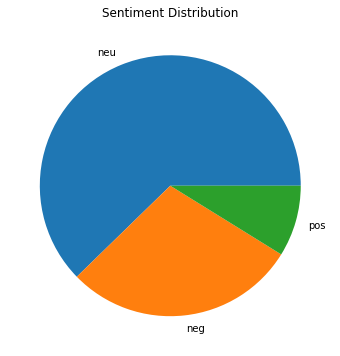

In [ ]:
df[['neu', 'neg', 'pos']].apply(pd.Series.value_counts).iloc[1,:].plot(kind="pie", figsize=(6,6), title="Sentiment Distribution", ylabel="")
plt.savefig('sentiment_distribution.png')

In [ ]:
df.value_counts('sentiment', normalize=True) * 100

sentiment
neu    62.287582
neg    28.888889
pos     8.823529
dtype: float64

&nbsp;

## 6.5 phi Coefficient

In [ ]:
df_coef = phi_coef_matrix(df, SOCIAL_FIELDS+RELIGIONS+['neg', 'neu', 'pos']+[1,2,3,4,5])

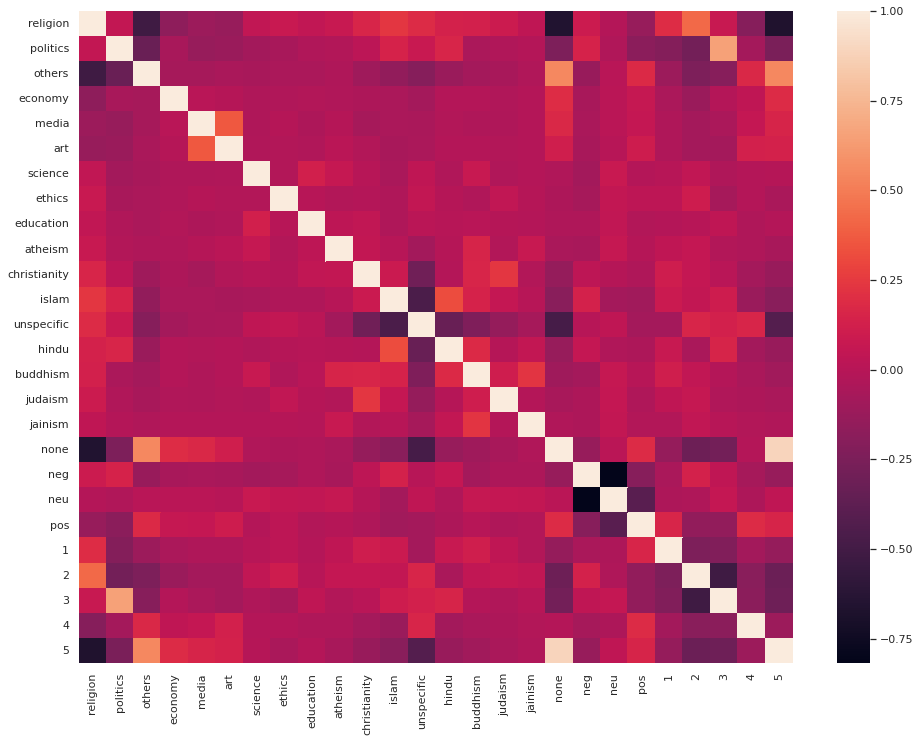

In [ ]:
sn.set(rc={"figure.figsize":(16, 12)})
sn.heatmap(df_coef)
plt.savefig("heatmap.png")

## 6.6 Clustering with k-modes
See also [this Medium article](https://medium.com/geekculture/the-k-modes-as-clustering-algorithm-for-categorical-data-type-bcde8f95efd7).

In [ ]:
### IMPORTS
!pip install kmodes

# Import module for linear algebra
import numpy as np
# Import module for data visualization
from plotnine import *
import plotnine

# Use the theme of ggplot
plt.style.use('ggplot')

# Import module for k-protoype cluster
from kmodes.kmodes import KModes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
cols_drop = ['text', 'hashtags', 'id', 'ron', 'religions', 'social_spheres', 'sentiment', 'clean_tweet']

In [ ]:
df_kmodes = df.drop(columns=cols_drop).astype("object")

In [ ]:
df_kmodes.nunique()

atheism         2
christianity    2
islam           2
unspecific      2
hindu           2
buddhism        2
judaism         2
others          2
jainism         2
none            2
religion        2
politics        2
economy         2
media           2
art             2
science         2
ethics          2
education       2
neg             2
neu             2
pos             2
1               2
2               2
3               2
4               2
5               2
dtype: int64

### Elbow Plot

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9


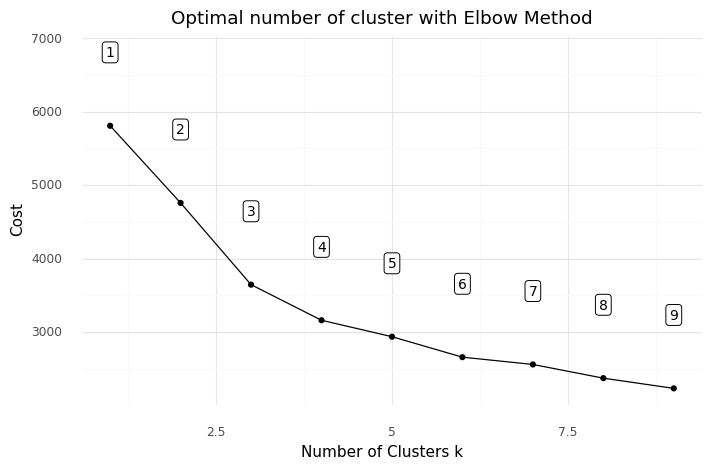

<ggplot: (8748431126709)>

In [ ]:
# Choosing optimal K
cost = []
for cluster in range(1, 10):
    try:
        kmodes = KModes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kmodes.fit_predict(df_kmodes)
        cost.append(kmodes.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster': range(1, 10), 'Cost': cost})
# Data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

The optimal number of clusters appears to be n=3.

In [ ]:
kmodes = KModes(n_jobs=-1, n_clusters=3, init="Huang", random_state=42)

In [ ]:
kmodes.fit_predict(df_kmodes)

array([1, 0, 0, ..., 1, 2, 1], dtype=uint16)

In [ ]:
pd.DataFrame(kmodes.cluster_centroids_, columns=df_kmodes.columns)

,atheism,christianity,islam,unspecific,hindu,buddhism,judaism,others,jainism,none,religion,politics,economy,media,art,science,ethics,education,neg,neu,pos,1,2,3,4,5
0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
2,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0


&nbsp;

# 7. DEEP LEARNING `RON`

In [ ]:
df_4training = df.drop("text", axis=1).rename(columns={'clean_tweet': 'text'})[['text','ron']]

## 7.1 Create DataLoader

In [ ]:
# for the language model
dls_lm = TextDataLoaders.from_df(df_4training, is_lm=True)

In [ ]:
# for the classification model
dls_clas = TextDataLoaders.from_df(df_4training, text_vocab=dls_lm.vocab)

In [ ]:
#dls_clas.show_batch()

## 7.2 Create Language Model

This is used to fine tune the AWD_LSTM with the tweets from the ReligionML Twitter data.

In [ ]:
twitter_lm = language_model_learner(dls_lm, AWD_LSTM, drop_mult=0.3, metrics=[accuracy, Perplexity()]).to_fp16()

SuggestedLRs(valley=0.0063095735386013985)

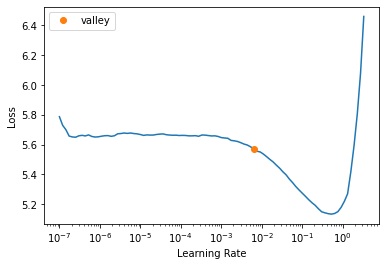

In [ ]:
twitter_lm.lr_find()

In [ ]:
twitter_lm.fine_tune(6, 6e-3, freeze_epochs=12)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.687728,5.718915,0.139891,304.574432,00:03
1,5.608562,5.642813,0.140842,282.255646,00:03
2,5.550507,5.525690,0.150845,251.059402,00:03
3,5.489932,5.374623,0.165768,215.858444,00:03
4,5.386940,5.214875,0.179264,183.988770,00:03
5,5.260417,5.065164,0.185960,158.406433,00:03
6,5.137884,4.942738,0.187944,140.153412,00:03
7,5.024584,4.845258,0.186673,127.136108,00:03
8,4.905882,4.772419,0.187572,118.204887,00:03
9,4.790359,4.728918,0.190941,113.173050,00:03


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.001183,4.655463,0.198041,105.157867,00:03
1,3.972033,4.673164,0.188719,107.035858,00:03
2,3.916646,4.639301,0.202639,103.472023,00:03
3,3.851752,4.639454,0.200169,103.487862,00:03
4,3.798469,4.647723,0.197596,104.347084,00:03
5,3.744921,4.648985,0.195964,104.478928,00:03


In [ ]:
twitter_lm.predict("islam", n_words=8)

'islam is an ecological issue it is considered by'

In [ ]:
twitter_lm.save_encoder('../gdrive/MyDrive/ft_twitter_religion_encoder')

## 7.3 Create Text Classifier

Creating the classifier based on the language model created above.

In [ ]:
learn_clas = text_classifier_learner(dls_clas, AWD_LSTM, metrics=accuracy).to_fp16()

In [ ]:
learn_clas = learn_clas.load_encoder('../gdrive/MyDrive/ft_twitter_religion_encoder')

SuggestedLRs(valley=0.001737800776027143)

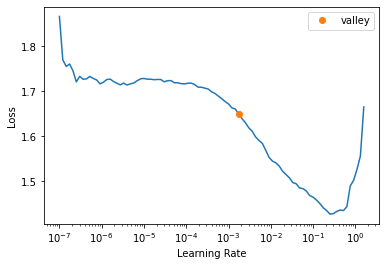

In [ ]:
learn_clas.lr_find()

Current top: 15.06.2022 acc 64.3% with `learn_clas.fine_tune(5, 2e-3, freeze_epochs=5)` 

In [ ]:
# 8 epochs
learn_clas.fine_tune(6, 3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy,time
0,1.644664,1.519014,0.428105,00:04
1,1.474869,1.203416,0.529412,00:03
2,1.343988,1.080539,0.588235,00:03
3,1.251086,1.034556,0.604575,00:03


epoch,train_loss,valid_loss,accuracy,time
0,1.009536,0.963167,0.637255,00:03
1,0.972442,0.957421,0.624183,00:03
2,0.913096,0.920724,0.660131,00:03
3,0.844054,0.894940,0.692810,00:03
4,0.778260,0.902582,0.692810,00:03
5,0.724334,0.907012,0.676471,00:03


## 7.4 Interpretation & Save Model

In [ ]:
# should be 1
learn_clas.predict(clean_tweet("Very accurate. Any god you deem fit to raise dagger and stone for is not religion but a compiled fallacy to dissuade the gullible ones."))

('1', TensorText(0), TensorText([0.5920, 0.2475, 0.0028, 0.1108, 0.0470]))

In [ ]:
# should be 2
learn_clas.predict(clean_tweet('I think religion is better than most people think.'))

('2', TensorText(1), TensorText([0.0351, 0.8634, 0.0585, 0.0225, 0.0205]))

In [ ]:
# should be 5
learn_clas.predict(clean_tweet('WTF are you doing.'))

('5', TensorText(4), TensorText([0.0087, 0.0222, 0.0099, 0.0825, 0.8768]))

In [ ]:
# should be 3
txt = "#LestWeForgetBabri #BabriMasjid \#LestWeForget Babri Masjid is not about a place of worship or about any religion. It reflects on the collective culture of a nation to ensure justice. A Supreme Court verdict coming up for review indicates its failure to uphold justice."
learn_clas.predict(clean_tweet(txt))

('3', TensorText(2), TensorText([0.0280, 0.1615, 0.7706, 0.0167, 0.0232]))

In [ ]:
# should be 4
learn_clas.predict(clean_tweet('music is my religion.'))

('4', TensorText(3), TensorText([0.0697, 0.0396, 0.0155, 0.8669, 0.0082]))

In [ ]:
# save model
learn_clas.export(DATA_PATH/'ft_twitter_religion_classifier.pkl')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_clas)

In [ ]:
interp.confusion_matrix()

array([[ 7,  8,  1,  1,  1],
       [ 6, 84, 16,  1,  2],
       [ 3, 32, 74,  0,  1],
       [ 0, 10,  4,  4,  2],
       [ 0,  2,  4,  5, 38]])

In [ ]:
interp.most_confused()

[(2, 3, 13),
 (1, 2, 11),
 (3, 2, 11),
 (2, 5, 6),
 (2, 4, 4),
 (3, 5, 4),
 (4, 3, 3),
 (5, 3, 3),
 (1, 3, 2),
 (3, 4, 2),
 (5, 1, 2),
 (5, 2, 2),
 (5, 4, 2),
 (2, 1, 1),
 (3, 1, 1),
 (4, 5, 1)]

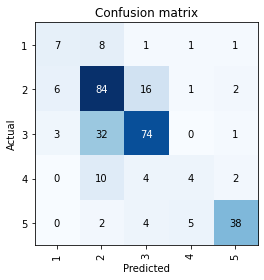

In [ ]:
interp.plot_confusion_matrix()
plt.tight_layout()
plt.savefig('confusion_ron_clas.png')

## 7.5 Testing

In [ ]:
df_test = create_full_df(path=DATA_PATH/'Twitter'/'Religion'/'DHQ'/'test')

In [ ]:
# load classifier
learner = load_learner(DATA_PATH/'ft_twitter_religion_classifier.pkl')

In [ ]:
learner.predict('hallO u dumb fuck')

('3', TensorText(2), TensorText([0.0171, 0.0333, 0.5589, 0.3093, 0.0814]))

In [ ]:
df_predictions = predict_tweets(df_test, learner)

In [ ]:
#df_predictions.head()

In [ ]:
# accuracy

len(df_predictions[df_predictions['ron'] == df_predictions['y_hat']]) / len(df_predictions)

0.48

# 8. DEEP LEARNING `sentiment`

## 8.1 Create DataLoader

In [ ]:
df_4training = df.drop("text", axis=1).rename(columns={'clean_tweet': 'text'})[['text', 'sentiment']]

In [ ]:
dls_clas = TextDataLoaders.from_df(df_4training, text_vocab=dls_lm.vocab, label_col='sentiment')

## 8.2 Create Text Classifier

In [ ]:
learn_clas = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()

In [ ]:
learn_clas = learn_clas.load_encoder('../gdrive/MyDrive/ft_twitter_religion_encoder')

SuggestedLRs(valley=0.0014454397605732083)

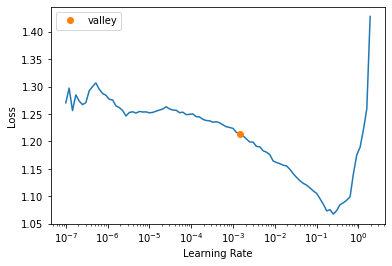

In [ ]:
learn_clas.lr_find()

In [ ]:
learn_clas.fine_tune(4,3e-3, freeze_epochs=8)

epoch,train_loss,valid_loss,accuracy,time
0,1.222066,1.073798,0.431373,00:03
1,1.159902,1.036322,0.464052,00:03
2,1.100372,1.002291,0.519608,00:03
3,1.058555,0.906304,0.575163,00:03
4,1.004257,0.917106,0.594771,00:03
5,0.946582,0.875919,0.630719,00:03
6,0.891674,0.830479,0.653595,00:03
7,0.836991,0.800389,0.627451,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.649397,0.777347,0.660131,00:03
1,0.634594,0.795781,0.650327,00:03
2,0.587824,0.761594,0.663399,00:03
3,0.536297,0.748270,0.647059,00:03


## 8.3 Interpretation & Save Model

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_clas)

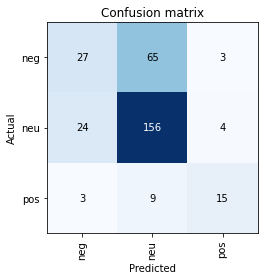

In [ ]:
interp.plot_confusion_matrix()
plt.tight_layout()
plt.savefig('confusion_sen_clas.png')

In [ ]:
# save model
learn_clas.export(DATA_PATH/'ft_twitter_sentiment_classifier.pkl')

# 9 DEEP LEARNING `religion`

## 9.1 Create DataLoader

In [ ]:
### 
df_4training = df.drop("text", axis=1).rename(columns={'clean_tweet': 'text'})[['text', 'religions']]

In [ ]:
# we need to create a Datablock here, the TextDataLoaders methods seems to be buggy
dblock = DataBlock(blocks=(TextBlock.from_df('text', vocab=dls_lm.vocab), MultiCategoryBlock), get_x=ColReader('text'), get_y=ColReader('religions', label_delim=' '))
#dls_clas = TextDataLoaders.from_df(df_4training, text_col='text', label_col='religions', label_delim=" ")

In [ ]:
dls_clas = dblock.dataloaders(df_4training)

## 9.2 Train Text Classifier

Funktioniert erstaunlich gut... mit `learn_clas.fine_tune(4,3e-3, freeze_epochs=5)` und `learn_clas = text_classifier_learner(dls_clas, AWD_LSTM, metrics=partial(accuracy_multi, thresh=0.8, sigmoid=False)).to_fp16()`

In [ ]:
learn_clas = text_classifier_learner(dls_clas, AWD_LSTM, metrics=partial(accuracy_multi, thresh=0.8)).to_fp16()

In [ ]:
learn_clas = learn_clas.load_encoder('../gdrive/MyDrive/ft_twitter_religion_encoder')

SuggestedLRs(valley=0.004365158267319202)

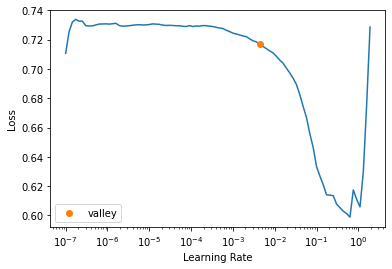

In [ ]:
learn_clas.lr_find()

In [ ]:
learn_clas.fine_tune(5,4e-3, freeze_epochs=5)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.720863,0.668599,0.886928,00:02
1,0.698602,0.641796,0.894771,00:02
2,0.673533,0.580656,0.908170,00:02
3,0.626485,0.420564,0.915360,00:02
4,0.530928,0.269106,0.916667,00:02


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.270594,0.226100,0.915359,00:02
1,0.248524,0.190227,0.924510,00:02
2,0.225987,0.176945,0.926797,00:02
3,0.206765,0.173384,0.925163,00:02
4,0.192721,0.172502,0.924510,00:02


## 9.3 Interpretation & Save Model

In [ ]:
learn_clas.predict(clean_tweet("It is a fight Hindus must win against Islamism terrorism and communism. Forget BJP be a Hindu, be united.Never link ur religion to a so called Hindu party https://t.co/LnBziegZ7F"))

((#2) ['hindu','islam'],
 TensorText([False, False, False,  True,  True, False, False, False, False, False]),
 TensorText([0.0448, 0.1877, 0.1427, 0.6290, 0.9055, 0.0837, 0.1320, 0.0643, 0.1093, 0.0552]))

In [ ]:
if 'muslim' in tweet and 'islam' not in category(religions):
  add 'islam' to category(religions)

In [ ]:
learn_clas.predict(clean_tweet('no i mean who in that thread is using their religion as an excuse to harm ppl?'))

((#1) ['unspecific'],
 TensorText([False, False, False, False, False, False, False, False, False,  True]),
 TensorText([0.0232, 0.0274, 0.0332, 0.0414, 0.0393, 0.0187, 0.0183, 0.0192, 0.0195, 0.9594]))

In [ ]:
# save model
learn_clas.export(DATA_PATH/'ft_twitter_religions_classifier.pkl')

# 10 DEEP LEARNING `social_fields` 

## 10.1 Create DataLoader

In [ ]:
df_4training = df.drop("text", axis=1).rename(columns={'clean_tweet': 'text'})[['text', 'social_spheres']]

In [ ]:
df_4training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1530 entries, 0 to 1529
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            1530 non-null   object
 1   social_spheres  1530 non-null   object
dtypes: object(2)
memory usage: 24.0+ KB


In [ ]:
#df_4training.value_counts('social_spheres')

In [ ]:
dblock = DataBlock(blocks=(TextBlock.from_df('text', vocab=dls_lm.vocab), MultiCategoryBlock), get_x=ColReader('text'), get_y=ColReader('social_spheres', label_delim=' '))

In [ ]:
df_4training.value_counts('social_spheres')

social_spheres
religion                     485
religion politics            238
politics religion            221
others                       165
politics                     152
                            ... 
politics media religion        1
politics media                 1
politics economy religion      1
media religion                 1
science religion               1
Length: 62, dtype: int64

In [ ]:
dls_clas = dblock.dataloaders(df_4training)

## 10.2 Train Text Classifier

In [ ]:
learn_clas = text_classifier_learner(dls_clas, AWD_LSTM, metrics=partial(accuracy_multi, thresh=0.8)).to_fp16()

In [ ]:
learn_clas = learn_clas.load_encoder('../gdrive/MyDrive/ft_twitter_religion_encoder')

SuggestedLRs(valley=0.0030199517495930195)

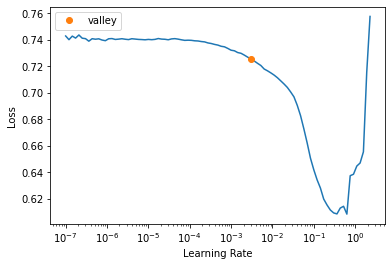

In [ ]:
learn_clas.lr_find()

In [ ]:
learn_clas.fine_tune(4, 3e-3, freeze_epochs=5)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.723588,0.668743,0.832970,00:04
1,0.701300,0.647415,0.844953,00:02
2,0.679886,0.635105,0.862745,00:02
3,0.650780,0.559282,0.878722,00:02
4,0.585132,0.399815,0.889978,00:02


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.371909,0.349114,0.896514,00:02
1,0.340833,0.297643,0.903413,00:02
2,0.308001,0.274300,0.902687,00:02
3,0.284741,0.262750,0.906318,00:02


## 10.3 Interpretation & Save Model

In [ ]:
learn_clas.predict("It is a fight Hindus must win against Islamism terrorism and communism. Forget BJP be a Hindu, be united.Never link ur religion to a so called Hindu party https://t.co/LnBziegZ7F")

((#2) ['politics','religion'],
 TensorText([False, False, False, False, False, False,  True,  True, False]),
 TensorText([0.0774, 0.0759, 0.0404, 0.1292, 0.0760, 0.0786, 0.8266, 0.6626, 0.0467]))

In [ ]:
# save model
learn_clas.export(DATA_PATH/'ft_twitter_social_fields_classifier.pkl')

# 11. Corpus Linguistics

This part prepares the tweets for an external analysis with the help of methods from the field of corpus linguistics. Currently, this means that one can filter the dataframe (preferably based on the clusters found during the exploratory data analysis) and lemmatize & store the tweets as txt files in a folder.

In [ ]:
# filter the dataframe (based on the clusters found previously);

df_filtered = df[(df.religion == 1) & (df[2] == 1) & (df.neu == 1)].reset_index()

In [ ]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321 entries, 0 to 320
Data columns (total 35 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           321 non-null    int64  
 1   id              321 non-null    float64
 2   text            321 non-null    object 
 3   hashtags        25 non-null     object 
 4   ron             321 non-null    int64  
 5   religions       321 non-null    object 
 6   social_spheres  321 non-null    object 
 7   sentiment       321 non-null    object 
 8   clean_tweet     321 non-null    object 
 9   atheism         321 non-null    int64  
 10  christianity    321 non-null    int64  
 11  islam           321 non-null    int64  
 12  unspecific      321 non-null    int64  
 13  hindu           321 non-null    int64  
 14  buddhism        321 non-null    int64  
 15  judaism         321 non-null    int64  
 16  others          321 non-null    int64  
 17  jainism         321 non-null    int

In [ ]:
df_filtered.head(3)

,index,id,text,hashtags,ron,religions,social_spheres,sentiment,clean_tweet,atheism,christianity,islam,unspecific,hindu,buddhism,judaism,others,jainism,none,religion,politics,economy,media,art,science,ethics,education,neg,neu,pos,1,2,3,4,5
0,213,1.537032e+18,"@captaincarot @brianmoore666 Where does it say ""Right to push your religion on someone else""?",NaN,2,unspecific,religion,neu,where does it say right to push your religion on someone else,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1,220,1.537032e+18,"@Karlton111 @HaddenKatie @Gr3yfox977 @MaryBruno_ @laurenboebert I wouldn't want to, it's better if people are kept in check. If you need a god and the Bible to set your morals for you than so be it. I don't need a fake religion to know right from wrong. It's only a problem when religion is mixed with government.",NaN,2,christianity unspecific,religion politics,neu,i wouldn t want to it s better if people are kept in check if you need a god and the bible to set your morals for you than so be it i don t need a fake religion to know right from wrong it s only a problem when religion is mixed with government,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0
2,221,1.537032e+18,@Sandchild_ @That_Starmerite Why are you afraid of equality? Because your religion taught you? Simpleton,NaN,2,unspecific,religion politics,neu,why are you afraid of equality because your religion taught you simpleton,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0


In [ ]:
len(df_filtered)

321

In [ ]:
folder_path = 'tweets_cl_religion/'

In [ ]:
save_tweets_for_corpus_linguistics(df_filtered, folder_path)

# 12. Qualitative Analysis

This section is used to search/filter certain tweets for a qualitative analysis.

In [ ]:
df_filtered[df_filtered.text.str.contains("respect")]

,index,id,text,hashtags,ron,religions,social_spheres,sentiment,clean_tweet,atheism,christianity,islam,unspecific,hindu,buddhism,judaism,others,jainism,none,religion,politics,economy,media,art,science,ethics,education,neg,neu,pos,1,2,3,4,5
61,449,1.538831e+18,"@saraf1997_ @AskAnshul Irrespective of any religion, even a new born kid who doesn't know what is his/her religion loves his mother. Respecting a mother=worshiping a mother. Respecting mother=Respecting women. Does that hurt you?",NaN,2,unspecific,religion others,neu,irrespective of any religion even a new born kid who doesn t know what is his her religion loves his mother respecting a mother worshiping a mother respecting mother respecting women does that hurt you,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
72,502,1.539143e+18,"@sus_what @Robotlnvader @Minecraft The man’s saying it’s his religion, he will disrespect his religion if he breaks the rule, and so people will be mad at him. Learn some manners and show respect.",NaN,2,unspecific,religion,neu,the man’s saying it’s his religion he will disrespect his religion if he breaks the rule and so people will be mad at him learn some manners and show respect,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
75,522,1.539143e+18,"The logic is that if you are intending to live or visit any country, then you should accept and respect its religion, laws and culture. Pretending that you are and advertizing the oposit is a problematic concept and a handicap thinking https://t.co/REw6eU4ILK",NaN,2,unspecific,religion politics,neu,the logic is that if you are intending to live or visit any country then you should accept and respect its religion laws and culture pretending that you are and advertizing the oposit is a problematic concept and a handicap thinking,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0
111,676,1.529900e+18,"@MonicaCarmean @YuriShirman @cumbia1329 @meganmmenchaca @WSJ Which makes absolutely no difference to those who choose to do so anyway. I have respect for religion but you must realise it was a construct made before sciences. There is no god, or higher power, it’s just a fact. There was no entity or being that came back from the dead. Sorry",NaN,2,unspecific,religion science,neu,which makes absolutely no difference to those who choose to do so anyway i have respect for religion but you must realise it was a construct made before sciences there is no god or higher power it’s just a fact there was no entity or being that came back from the dead sorry,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0
192,1056,1.532615e+18,"@Shivamsbisht @chitta2021 @SortedEagle Hindus and Muslims should stop such acts. Hinduism doesnt allow to disrespect any other religion. All Hindus who live in Hindusthan should live like Vasudevakutumbakam irrespective of Caste Religion Community. Hindu, Sikh, Isaye Muslim bhai bhai. Jai Bharath! Jai Hinduism.",NaN,2,islam hindu,religion,neu,hindus and muslims should stop such acts hinduism doesnt allow to disrespect any other religion all hindus who live in hindusthan should live like vasudevakutumbakam irrespective of caste religion community hindu sikh isaye muslim bhai bhai jai bharath! jai hinduism,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
215,1106,1.532614e+18,"@MorganMcCabe19 @Deestinyer @FaZeClan We are under absolutely zero obligation to respect this dude's religion that thinks LGBT+ people don't deserve basic human rights. Homophobia deserves to be eliminated, and the world is better for it. In order for a tolerant society to exist, it must be intolerant of intolerance.",NaN,2,unspecific,religion politics,neu,we are under absolutely zero obligation to respect this dude s religion that thinks lgbt people don t deserve basic human rights homophobia deserves to be eliminated and the world is better for it in order for a tolerant society to exist it must be intolerant of intolerance,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0
230,1153,1.534114e+18,@KDSi